In [1]:
!pip install tf_keras_vis -q
!pip install tensorflow_addons -q
!pip install keras_tuner -q

     |████████████████████████████████| 53 kB 1.2 MB/s 
     |████████████████████████████████| 1.1 MB 12.0 MB/s 
     |████████████████████████████████| 98 kB 4.0 MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from operator import itemgetter
import random

import keras
import tensorflow as tf
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Flatten, Concatenate, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from sklearn.preprocessing import StandardScaler
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.losses import BinaryCrossentropy
import keras_tuner as kt

from sklearn.metrics import accuracy_score, roc_auc_score
from google.colab import files

### Load Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/Innolab")
import data_loader as dtl
from reorder_matrices_regions import reorder_matrices_regions
from viz_utils import ordered_regions
from E2E_conv import E2E_conv
from data_preparation import prepare_data

# import nn_modelling_utils as ut

### Preprocessing and preperation for CNN

In [5]:
# PATH  = "/content/drive/MyDrive/Colab Notebooks/Innolab/data/Updated/"

# #load data from csv
# test = pd.read_csv(PATH + "test.csv")
# train = pd.read_csv(PATH + "train.csv")

PATH  = "/content/drive/MyDrive/Colab Notebooks/Innolab/"

#load data from csv
test = pd.read_csv(PATH + "delcode_test.csv", index_col = 0)
train = pd.read_csv(PATH + "delcode_train.csv", index_col = 0)

In [ ]:
train['prmdiag'].unique()

In [10]:
train.head()

age       sex   edyears  ...   244_246   245_246  target
855 -0.295663  0.497994 -0.380863  ... -0.120295  0.485787     1.0
387 -0.784678  0.497994 -1.030316  ... -0.799928 -1.116423     1.0
857  0.519362  0.497994 -0.705589  ...  0.301496  2.292690     1.0
755 -0.784678 -1.130230 -0.380863  ... -0.748722 -1.115578     1.0
580  0.519362  0.497994 -0.380863  ... -2.153692 -0.630131     1.0

[5 rows x 30139 columns]

In [ ]:
data = pd.concat([train, test])
classification = True
columns_drop = ["ConnID", "Repseudonym", "siteid", "visdat", "MEM_score", "Apoe", "IDs"]
#columns_drop = ["ConnID", "Repseudonym", "siteid", "visdat", "MEM_score", "Apoe", "IDs", 'age', 'sex', 'edyears']
target = "prmdiag"
y_0 = [0]
y_1 = [2, 3]
train_size = 0.8
seed = 123
split = True

In [ ]:
ytrain, Xtrain, ytest, Xtest = prepare_data(data = data, classification = classification,
                         columns_drop = columns_drop, target = target, y_0 = y_0, y_1 = y_1,
                         train_size = train_size, seed = seed, split = split)

In [45]:
X_train = train.drop(['target'], axis = 1)
y_train = train['target']
X_test = test.drop(['target'], axis = 1)
y_test = test['target']

NameError: ignored

In [16]:
def flat_to_mat_aggregation(x: np.ndarray) -> np.ndarray:
    """
    - converts a flat np.array into a matrix by turning
      the values of the array into a symmetric matrix
    - excluding diagonal

    Args:
         x: 1D array which should be turned into symmetric matrix

    Returns:
         np.ndarray - matrix

    """

    n = len(x)
    n_a = 8
    A = np.zeros(n_a * n_a).reshape(n_a, n_a)
    ind = np.triu_indices(n_a, k=0)
    A[ind] = x
    return A.T + A

In [17]:
def augmented_data(x: pd.DataFrame, y: pd.Series, X_img_cols: list, X_struc_cols: list, sd = 0.17, augm_fact = 5):
    
    x_aug = np.array(x[X_img_cols].copy())
    noise = np.random.normal(
        scale=sd,
        size=x_aug.shape[0]*x_aug.shape[1]*augm_fact).reshape(
            x_aug.shape[0]*augm_fact, x_aug.shape[1])
    x_aug = np.vstack([x_aug]*augm_fact)  + noise
    x_struc_aug = np.vstack([np.array(x[X_struc_cols])]*augm_fact)
    y_aug = np.hstack([np.array(y)]*augm_fact)

    return pd.DataFrame(x_aug, columns=X_img_cols), pd.DataFrame(x_struc_aug, columns=X_struc_cols), y_aug


In [19]:
def data_augmentation_gaussian(X,X_struc, y, scale = .07, aug_size = 5000):
    ##kann man noch beschleunigen oder?

    ##zerstoert komplett den ram, braucht viel zu viel speicher... batches????

    # #draw random sample
    # idx = np.random.choice(range(X.shape[0]), size=aug_size, replace=True)

    # #add gaussian noise
    # noise = np.random.normal(loc = 0, scale = scale, size = (aug_size, X.shape[1], X.shape[2], 1))

    # X_noise = X[idx] + np.triu(noise, k=1).reshape(aug_size, X.shape[1], X.shape[2], 1) + np.triu(noise, k=1).T.reshape(aug_size, X.shape[1], X.shape[2], 1)
    # X_struc_noise = X_struc[idx]
    # y_noise = y[idx]

    # return np.concatenate((X, X_noise), axis=0), np.concatenate((X_struc, X_struc_noise), axis=0), np.concatenate((y, y_noise), axis=0)

    #dauert viel zu lange...
    print(aug_size)
    for i in range(aug_size):
        #draw random sample

        idx = random.randint(0,X.shape[0]-1)

        #add gaussian noise
        noise = np.random.normal(loc = 0, scale = scale, size = (X.shape[1], X.shape[2], 1))
        X_noise = X[idx] + np.triu(noise, k=1).reshape(X.shape[1], X.shape[2], 1) + np.triu(noise, k=1).T.reshape(X.shape[1], X.shape[2], 1)

        # append to dataset
        X = np.concatenate((X, X_noise.reshape(1,X.shape[1], X.shape[2], 1)), axis=0)
        X_struc = np.concatenate((X_struc, X_struc[idx].reshape(1, X_struc.shape[1])), axis=0)
        y = np.concatenate((y, y[idx].reshape((1,))), axis=0)

        if i % 100 == 0:
            print(r"Current epoch {}".format(i))


    return X, X_struc, y

    # X_noise = X.copy()
    # X_struc_noise = X_struc.copy()
    # y_noise = y.copy()

    # for i in range(X.shape[0]):
    #     # add gaussian noise
    #     noise = np.random.normal(loc=0, scale=scale, size=(X.shape[1], X.shape[2], 1))
    #     X_noise[i] = X[i] + np.triu(noise, k=1).reshape(X.shape[1], X.shape[2], 1) + np.triu(noise, k=1).T.reshape(
    #         X.shape[1], X.shape[2], 1)

    # return np.concatenate((X, X_noise), axis=0), np.concatenate((X_struc, X_struc_noise), axis=0), np.concatenate(
    #     (y, y_noise), axis=0)


In [20]:
def preprocess_for_cnn(X,y, aggregation=True, augmentation=False, scale=.07, augmentation_factor = 5):
    # create target

    X_img_cols = []
    X_struc_cols= []
    for x in X.columns:
        if len(x.split("_"))>1 and x.split("_")[0].isdigit() and x.split("_")[1].isdigit():
            X_img_cols.append(x)
        else:
            X_struc_cols.append(x)

    if augmentation:
        print("Starting Data Augmentation")
        X_img_aug, X_struc_aug, y_aug = augmented_data(X, y, X_img_cols, X_struc_cols, sd=scale, augm_fact = augmentation_factor)
        #merging augmented data with input data
        X_img = pd.concat([X[X_img_cols], X_img_aug])
        X_struc = pd.concat([X[X_struc_cols], X_struc_aug])
        y = np.concatenate([np.array(y), y_aug], axis = 0)
    else:
        X_img = X[X_img_cols]
        X_struc = X[X_struc_cols]

    print("Turning flat array to matrix")
    # turn flat array to matrix
    if aggregation:
        n_c = 8
        n_train = len(X_img)
        X_train_2d = np.zeros(n_train * n_c * n_c).reshape(n_train, n_c, n_c)

        # turn array to matrix
        for i in range(n_train):
            X_train_2d[i] = flat_to_mat_aggregation(X_img.iloc[i, :])

        stacked = np.stack(X_train_2d, axis=0)

    else:
        n_c = dtl.flat_to_mat(X_img.iloc[0, :]).shape[0]
        n_train = len(X_img)
        X_train_2d = np.zeros(n_train * n_c * n_c).reshape(n_train, n_c, n_c)

        # turn array to matrix
        for i in range(n_train):
            X_train_2d[i] = dtl.flat_to_mat(X_img.iloc[i, :])

        stacked = np.stack(reorder_matrices_regions(X_train_2d, network='yeo7'), axis=0)

    # reshape data
    X_img = stacked.reshape(stacked.shape[0], stacked.shape[1], stacked.shape[2], 1)
    if X_struc.shape[1] != 0:
          X_struc = X_struc.to_numpy().reshape(stacked.shape[0], 3)
    else:
        X_struc = X_struc.to_numpy()

    return X_img, X_struc, y


In [21]:
X_aug, X_aug_struc, y_aug = preprocess_for_cnn(X_train,y_train, aggregation = False, augmentation = True, scale = 0.03, augmentation_factor = 4)
# X_test, X_test_struc, y_test = preprocess_pipeline(test, aggregation = False, train_data = False, augmentation = False)

Starting Data Augmentation
Turning flat array to matrix


In [22]:
print(X_aug.shape)
print(X_aug_struc.shape)
print(y_aug.shape)

(1880, 246, 246, 1)
(1880, 3)
(1880,)


In [47]:
X_test, X_test_struc, y_test = preprocess_for_cnn(X_test,y_test, aggregation = False, augmentation = False)

Turning flat array to matrix


In [166]:
y_test.reset_index(drop=True, inplace = True)

In [23]:
# Train val split
shuffled_indices = list(range(len(X_aug)))
random.shuffle(shuffled_indices)

train_idxs = shuffled_indices[:1800]
val_idxs = shuffled_indices[1800:]

val_x = X_aug[val_idxs]
val_x_struc = X_aug_struc[val_idxs]
val_y = y_aug[val_idxs]

train_x = X_aug[train_idxs]
train_x_struc = X_aug_struc[train_idxs]
train_y = y_aug[train_idxs]

In [ ]:
## TODO: Implement CCNN https://www.researchgate.net/publication/318652568_Resting_State_fMRI_Functional_Connectivity-Based_Classification_Using_a_Convolutional_Neural_Network_Architecture/link/5978a095aca27203ecc4a2a1/download 

### Models

####Conv1d

In [ ]:
from keras.layers import Conv1D

In [ ]:
train_1d_img = Xtrain.drop(['sex','age','edyears'], axis = 1)
train_1d_struc = Xtrain[['sex','age','edyears']]
test_1d_img = Xtest.drop(['sex','age','edyears'], axis = 1)
test_1d_struc = Xtest[['sex','age','edyears']]

In [ ]:
X_train_1d_img = np.array(train_1d_img)
X_train_1d_struc = np.array(train_1d_img)
X_test_1d_img = np.array(test_1d_img)
X_test_1d_struc = np.array(test_1d_img)


In [ ]:
model_1d = compose_cnn_1d_model()

ValueError: ignored

In [ ]:
dense_net = compose_dense_model((int(246*245/2)+3))

In [ ]:
dense_net.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30138)]           0         
                                                                 
 flatten_4 (Flatten)         (None, 30138)             0         
                                                                 
 dense_16 (Dense)            (None, 32)                964448    
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 32)                1056      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_18 (Dense)            (None, 16)                528 

In [ ]:
model_evaluation(dense_net, np.array(Xtest), ytest)

Accuracy  Precision    Recall    F1       AUC
0  0.765957   0.795918  0.764706  0.78  0.854081

In [ ]:
dense_net.fit(np.array(Xtrain), ytrain, epochs=100, batch_size=32, verbose=1)

In [ ]:
def compose_dense_model(input_shape: tuple, output_dim: int = 10,
                      act: str = "relu", opt = Adam(), loss = "binary_crossentropy") -> Sequential:

  input = Input(shape=input_shape)
  x = Flatten()(input)
  #x = Dropout(0.1)(x)

  x = Dense(32, activation=act)(x)
  x = Dropout(0.2)(x)
  x = Dense(32, activation=act)(x)
  x = Dropout(0.2)(x)
  x = Dense(16, activation=act)(x)
  x = Dropout(0.2)(x)
  out = Dense(1, activation="sigmoid")(x)

  model = Model(inputs=[input], outputs=out)
  model.compile(loss=loss,
                optimizer=opt, metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])
  

  return model


In [ ]:
def compose_cnn_1d_model(input_shape_cnn: tuple = (1,int(246*245/2)), input_shape_rest: tuple = (3,), output_dim: int = 1,
                      act: str = "relu", opt = Adam(), loss = "binary_crossentropy") -> Sequential:
  
  #first input for connectivity matrix data
  first_input = Input(shape=input_shape_cnn)

  x = Conv1D(32, kernel_size=(1,3), activation=act, name='1')(first_input)

  x = Conv1D(16, kernel_size=(1,3), activation=act, name='2')(x)

  x = Conv1D(16, kernel_size=(1,3), activation=act, name='3')(x)
  #x = MaxPooling1D(pool_size=(4))(x)

  #x = Dropout(0.25)(x)
  x = Flatten()(x)
  #x = Dropout(0.25)(x)

  #second input for other data (age, sex, ...)
  second_input = Input(shape=input_shape_rest)
  x = Concatenate(axis = -1)([x, second_input])
  #x = Dropout(0.5)(merged)

  #dense part of the network
  x = Dense(32, activation=act)(x)
  x = Dropout(0.2)(x)
  x = Dense(16, activation=act)(x)
  x = Dropout(0.2)(x)
  out = Dense(output_dim, activation="sigmoid")(x)
  
  model = Model(inputs=[first_input], outputs=out)
  #model = Model(inputs=[first_input, second_input], outputs=out)
  model.compile(loss=loss,
                optimizer=opt, metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])
  

  return model

####BrainnetCNN

In [41]:
def brain_net_cnn(input_dim_img, input_dim_struc, output_dim: int = 1, kernel_regularizer  = keras.regularizers.l2(0.01),
                  kernel_initializer = 'he_uniform', dropout_rate = 0.4, opt = Adam(), activation = 'relu', loss = "binary_crossentropy"):
    
    #Source: https://kawahara.ca/convolutional-neural-networks-for-adjacency-matrices/
    input_img = Input(shape=input_dim_img, name='input_img')

    x = E2E_conv(rank = 2, filters = 16, kernel_size = (2,input_dim_img[0]),kernel_regularizer=kernel_regularizer, input_shape=(input_dim_img[0],input_dim_img[1],input_dim_img[2]),
                 activation=activation,data_format="channels_last")(input_img)
    x = BatchNormalization()(x)

    x = E2E_conv(rank = 2, filters = 16, kernel_size = (2,input_dim_img[0]),kernel_regularizer=kernel_regularizer, input_shape=(input_dim_img[0],input_dim_img[1],input_dim_img[2]),
                 activation=activation,data_format="channels_last")(x)

    x = BatchNormalization()(x)
    x = Conv2D(filters=24, kernel_size=(1, input_dim_img[0]), strides=(1, 1),
                                  padding='valid',
                                  kernel_regularizer=kernel_regularizer,
                                  kernel_initializer=kernel_initializer, activation=activation, name='Edge-to-Node')(x)

    x = BatchNormalization()(x)
    x = Conv2D(filters=48, kernel_size=(input_dim_img[1], 1), strides=(1, 1),
                                  padding='valid',
                                  kernel_regularizer=kernel_regularizer,
                                  kernel_initializer=kernel_initializer, activation=activation, name='Node-to-Graph')(x)

    x = Dropout(.2)(x)
    x = Flatten()(x)

    #add strutural data such as age, etc.
    input_struc = Input(shape=input_dim_struc, name='input_struc')

    x = Concatenate(axis = -1)([x,input_struc])

    x = Dense(64,kernel_initializer=kernel_initializer, activation=activation)(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(64,kernel_initializer=kernel_initializer, activation=activation)(x)
    x = Dropout(dropout_rate)(x)

    out = Dense(output_dim, activation="sigmoid")(x)


    #compile model
    model = Model(inputs=[input_img, input_struc], outputs=out, name = 'BrainNetCNN')
    
    model.compile(loss=loss,
                  optimizer=opt,
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                          tf.keras.metrics.FalseNegatives()])
  
    return model

In [38]:
def ccnn(input_dim_img, input_dim_struc, output_dim: int = 1, kernel_regularizer  = keras.regularizers.l2(0.0005),
                  kernel_initializer = 'he_uniform', dropout_rate = 0.5, opt = Adam(), activation = LeakyReLU(alpha=0.33), loss = "binary_crossentropy"):
    
    #Source: https://kawahara.ca/convolutional-neural-networks-for-adjacency-matrices/
    input_img = Input(shape=input_dim_img, name='input_img')

    x = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1),
                                  padding='valid',
                                  kernel_regularizer=kernel_regularizer,
                                  kernel_initializer=kernel_initializer, activation=activation, name='1-to-1')(input_img)

    x = Conv2D(filters=64, kernel_size=(1, input_dim_img[0]), strides=(1, 1),
                                  padding='valid',
                                  kernel_regularizer=kernel_regularizer,
                                  kernel_initializer=kernel_initializer, activation=activation, name='Edge-to-Node')(x)

    x = Conv2D(filters=64, kernel_size=(input_dim_img[1], 1), strides=(1, 1),
                                  padding='valid',
                                  kernel_regularizer=kernel_regularizer,
                                  kernel_initializer=kernel_initializer, activation=activation, name='Node-to-Graph')(x)

    x = Dropout(dropout_rate)(x)
    x = Flatten()(x)

    #add strutural data such as age, etc.
    input_struc = Input(shape=input_dim_struc, name='input_struc')

    x = Concatenate(axis = -1)([x,input_struc])

    x = Dense(128,kernel_initializer=kernel_initializer, activation=activation)(x)
    x = Dropout(dropout_rate)(x)

    out = Dense(output_dim, activation="sigmoid")(x)

    #compile model
    model = Model(inputs=[input_img, input_struc], outputs=out)
    
    model.compile(loss=loss,
                  optimizer=opt,
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                          tf.keras.metrics.FalseNegatives()])
  
    return model

In [ ]:
def brain_net_cnn_tuning(hp):
    
    input_dim_img = (246,246,1)
    input_dim_struc = 3
    output_dim = 1
    kernel_regularizer = keras.regularizers.l2(0.0005)
    kernel_initializer = 'he_uniform'
    dropout_rate = 0.5,
    opt = Adam()
    activation = 'relu'
    loss = "binary_crossentropy"

    hp_filters_1 = hp.Int('filters_hp_1', min_value = 16, max_value = 64, step = 16)
    hp_filters_2 = hp.Int('filters_hp_2', min_value = 32, max_value = 128, step = 32)
    
    hp_dropout = hp.Float('dropout', 0, 0.6, step=0.1)

    #dense units
    hp_units=hp.Int("units", min_value=32, max_value=256, step=32)

    hp_learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    #Source: https://kawahara.ca/convolutional-neural-networks-for-adjacency-matrices/
    input_img = Input(shape=input_dim_img, name='input_img')

    x = E2E_conv(rank = 2, filters = hp_filters_1, kernel_size = (2,input_dim_img[0]),kernel_regularizer=kernel_regularizer, input_shape=(input_dim_img[0],input_dim_img[1],input_dim_img[2]),
                 activation=activation,data_format="channels_last")(input_img)

    x = E2E_conv(rank = 2, filters = hp_filters_1, kernel_size = (2,input_dim_img[0]),kernel_regularizer=kernel_regularizer, input_shape=(input_dim_img[0],input_dim_img[1],input_dim_img[2]),
                 activation=activation,data_format="channels_last")(x)

    x = Conv2D(filters=hp_filters_2, kernel_size=(1, input_dim_img[0]), strides=(1, 1),
                                  padding='valid',
                                  kernel_regularizer=kernel_regularizer,
                                  kernel_initializer=kernel_initializer, activation=activation, name='Edge-to-Node')(x)

    x = Conv2D(filters=hp_filters_2, kernel_size=(input_dim_img[1], 1), strides=(1, 1),
                                  padding='valid',
                                  kernel_regularizer=kernel_regularizer,
                                  kernel_initializer=kernel_initializer, activation=activation, name='Node-to-Graph')(x)

    x = Dropout(hp_dropout)(x)
    x = Flatten()(x)

    #add strutural data such as age, etc.
    input_struc = Input(shape=input_dim_struc, name='input_struc')

    x = Concatenate(axis = -1)([x,input_struc])


    


    x = Dense(hp_units,kernel_initializer=kernel_initializer, activation=activation)(x)
    x = Dropout(hp_dropout)(x)

    x = Dense(hp_units,kernel_initializer=kernel_initializer, activation=activation)(x)
    x = Dropout(hp_dropout)(x)

    out = Dense(output_dim, activation="sigmoid")(x)

    #compile model
    model = Model(inputs=[input_img, input_struc], outputs=out)
    
    model.compile(loss=loss,
                  optimizer=Adam(learning_rate=hp_learning_rate),
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                          tf.keras.metrics.FalseNegatives()])
  
    return model

In [ ]:
brain_net_cnn_tuning(kt.HyperParameters())

In [ ]:
tuner = kt.RandomSearch(
    hypermodel=brain_net_cnn_tuning,
    objective="val_binary_accuracy",
    max_trials=8,
    executions_per_trial=2,
    overwrite=True,
    project_name="Brainnet",
)

tuner.search_space_summary()

Search space summary
Default search space size: 5
filters_hp_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
filters_hp_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.6, 'step': 0.1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search([train_x, train_x_struc], train_y, epochs=5, validation_data=([val_x, val_x_struc], val_y))

Trial 8 Complete [00h 01m 20s]
val_binary_accuracy: 1.0

Best val_binary_accuracy So Far: 1.0
Total elapsed time: 00h 28m 38s
INFO:tensorflow:Oracle triggered exit


In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.

best_model.build(input_shape=(None, 246, 246, 1))
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 246, 246, 1  0           []                               
                                )]                                                                
                                                                                                  
 e2e_conv (E2E_conv)            (None, 246, 246, 48  23616       ['input_img[0][0]']              
                                )                                                                 
                                                                                                  
 e2e_conv_1 (E2E_conv)          (None, 246, 246, 48  1133568     ['e2e_conv[0][0]']               
                                )                                                             

In [ ]:
tuner.results_summary()

In [ ]:
def ccnn_model_with_struc(input_dim_img, input_dim_struc, output_dim: int = 1, kernel_regularizer  = keras.regularizers.l2(0.00005),
                          kernel_initializer = 'he_uniform', dropout_rate = 0.2, opt = Adam(),  activation = "relu", loss = "binary_crossentropy"):

    input_img = Input(shape=input_dim_img, name='input_img')

    #add strutural data such as age, etc.
    input_struc = Input(shape=input_dim_struc, name='input_struc')

    # create model
    x = Conv2D(filters=96, kernel_size=(1, input_dim_img[0]), strides=(1, 1),
                                  padding='valid',
                                  kernel_regularizer=kernel_regularizer,
                                  kernel_initializer=kernel_initializer, activation=activation, name='Edge-to-Node')(input_img)

    x = Conv2D(filters=128, kernel_size=(input_dim_img[1], 1), strides=(1, 1),
                                  padding='valid',
                                  kernel_regularizer=kernel_regularizer,
                                  kernel_initializer=kernel_initializer, activation=activation, name='Node-to-Graph')(x)

    x = Dropout(dropout_rate)(x)
    x = Flatten()(x)

    x = Concatenate(axis = -1)([x,input_struc])

    x = Dense(256,kernel_initializer=kernel_initializer, activation=activation)(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(256,kernel_initializer=kernel_initializer, activation=activation)(x)
    x = Dropout(dropout_rate)(x)

    out = Dense(output_dim, activation="sigmoid")(x)


    #compile model
    model = Model(inputs=[input_img, input_struc], outputs=out)
    
    model.compile(loss=loss,
                  optimizer=opt,
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                          tf.keras.metrics.FalseNegatives()])
  
    return model

In [ ]:
def ccnn(input_dim_img, output_dim: int = 1, kernel_regularizer  = keras.regularizers.l2(0.0005),
                  kernel_initializer = 'he_uniform', dropout_rate = 0.5, opt = Adam(), activation = LeakyReLU(alpha=0.33), loss = "binary_crossentropy"):
    
    #Source: https://kawahara.ca/convolutional-neural-networks-for-adjacency-matrices/
    input_img = Input(shape=input_dim_img, name='input_img')

    x = Conv2D(filters=32, kernel_size=(1, input_dim_img[0]), strides=(1, 1),
                                  padding='valid',
                                  kernel_regularizer=kernel_regularizer,
                                  kernel_initializer=kernel_initializer, activation=activation, name='Edge-to-Node')(input_img)

    x = Conv2D(filters=64, kernel_size=(input_dim_img[1], 1), strides=(1, 1),
                                  padding='valid',
                                  kernel_regularizer=kernel_regularizer,
                                  kernel_initializer=kernel_initializer, activation=activation, name='Node-to-Graph')(x)

    x = Dropout(dropout_rate)(x)
    x = Flatten()(x)

    #add strutural data such as age, etc.

    x = Dense(128,kernel_initializer=kernel_initializer, activation=activation)(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(128,kernel_initializer=kernel_initializer, activation=activation)(x)
    x = Dropout(dropout_rate)(x)

    out = Dense(output_dim, activation="sigmoid")(x)

    #compile model
    model = Model(inputs=[input_img], outputs=out)
    
    model.compile(loss=loss,
                  optimizer=opt,
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                          tf.keras.metrics.FalseNegatives()])
  
    return model

In [ ]:
def test_model(input_dim_img, output_dim: int = 1, kernel_regularizer  = keras.regularizers.l2(0.0005),
               kernel_initializer = 'he_uniform', dropout_rate = 0.5, opt = Adam(), loss = "binary_crossentropy"):

    input_img = Input(shape=input_dim_img, name='input_img')

    x = E2E_conv(rank = 2, filters = 32, kernel_size = (2,input_dim_img[0]),kernel_regularizer=kernel_regularizer, input_shape=(input_dim_img[0],input_dim_img[1],input_dim_img[2]),
                 activation=LeakyReLU(alpha=0.33),data_format="channels_last")(input_img)

    x = E2E_conv(rank = 2, filters = 32, kernel_size = (2,input_dim_img[0]),kernel_regularizer=kernel_regularizer, input_shape=(input_dim_img[0],input_dim_img[1],input_dim_img[2]),
                 activation=LeakyReLU(alpha=0.33),data_format="channels_last")(x)

    x = Conv2D(filters=64, kernel_size=(1, input_dim_img[0]), strides=(1, 1),
                                  padding='valid',
                                  kernel_regularizer=kernel_regularizer,
                                  kernel_initializer=kernel_initializer, activation=LeakyReLU(alpha=0.33), name='Edge-to-Node')(x)

    x = Conv2D(filters=64, kernel_size=(input_dim_img[1], 1), strides=(1, 1),
                                  padding='valid',
                                  kernel_regularizer=kernel_regularizer,
                                  kernel_initializer=kernel_initializer, activation=LeakyReLU(alpha=0.33), name='Node-to-Graph')(x)

    x = Dropout(dropout_rate)(x)
    x = Flatten()(x)

    x = Dense(128,kernel_initializer=kernel_initializer, activation=LeakyReLU(alpha=0.33))(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(128,kernel_initializer=kernel_initializer, activation=LeakyReLU(alpha=0.33))(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(output_dim)(x)
    out = keras.layers.Activation('sigmoid')(x)

    #compile model
    model = Model(inputs=input_img, outputs=out)
    
    model.compile(loss=loss,
                  optimizer=opt,
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                          tf.keras.metrics.FalseNegatives()])
  
    return model

### Training

In [28]:
batch_size = 32
epochs = 200
lr = 0.001
patience = 4
opt = Nadam()
#opt = Adam(learning_rate=lr)
input_shape_2d = (X_aug.shape[1], X_aug.shape[2], 1)
input_struc_dim = (X_aug_struc.shape[1])

In [29]:
input_struc_dim

3

In [42]:
#ccnn_model = ccnn(input_dim_img = input_shape_2d,output_dim = 1, opt = opt, activation = "relu")
#ccnn_with_struc = ccnn_model_with_struc(input_dim_img = input_shape_2d, input_dim_struc = input_struc_dim, output_dim = 1, opt = opt, activation = "relu", dropout_rate = .2)
brainnetcnn = brain_net_cnn(input_dim_img = input_shape_2d, input_dim_struc = input_struc_dim, output_dim = 1, opt = opt, activation = "relu", dropout_rate = .4)
#test = test_model(input_dim_img = input_shape_2d, output_dim = 1, opt = opt)

#print(ccnn_model.summary())
#print(ccnn_with_struc.summary())
print(brainnetcnn.summary())
#print(test.summary)

Model: "BrainNetCNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 246, 246, 1  0           []                               
                                )]                                                                
                                                                                                  
 e2e_conv_4 (E2E_conv)          (None, 246, 246, 16  7872        ['input_img[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 246, 246, 16  64         ['e2e_conv_4[0][0]']             
 rmalization)                   )                                                       

In [ ]:
train_2d = tf.data.Dataset.from_tensor_slices((train_x, train_x_struc, train_y))
#train_2d = tf.data.Dataset.from_tensor_slices((train_x, train_y))

SHUFFLE_BUFFER_SIZE = 100

train_2d_batch = train_2d.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)

In [ ]:
train_x.shape

(1800, 246, 246, 1)

In [ ]:
train_x_struc.shape

(1800, 3)

In [43]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=patience)
brainnet_fit = brainnetcnn.fit([train_x, train_x_struc], train_y, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=([val_x, val_x_struc], val_y), callbacks=[callback])
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
# ccnn_model_fit = ccnn_model.fit([train_x, train_x_struc], train_y, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=([val_x, val_x_struc], val_y), callbacks=[callback])

Epoch 1/200
57/57 [==============================] - 16s 196ms/step - loss: 5.5223 - binary_accuracy: 0.5944 - false_negatives_2: 370.0000 - val_loss: 5.0249 - val_binary_accuracy: 0.7375 - val_false_negatives_2: 0.0000e+00
Epoch 2/200
57/57 [==============================] - 10s 179ms/step - loss: 3.2984 - binary_accuracy: 0.7339 - false_negatives_2: 255.0000 - val_loss: 2.3296 - val_binary_accuracy: 0.9000 - val_false_negatives_2: 1.0000
Epoch 3/200
57/57 [==============================] - 10s 174ms/step - loss: 1.9166 - binary_accuracy: 0.8717 - false_negatives_2: 123.0000 - val_loss: 1.5812 - val_binary_accuracy: 0.9625 - val_false_negatives_2: 3.0000
Epoch 4/200
57/57 [==============================] - 10s 174ms/step - loss: 1.1934 - binary_accuracy: 0.9411 - false_negatives_2: 56.0000 - val_loss: 1.0826 - val_binary_accuracy: 0.9375 - val_false_negatives_2: 4.0000
Epoch 5/200
57/57 [==============================] - 10s 174ms/step - loss: 0.7982 - binary_accuracy: 0.9667 - false_

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=patience)
ccnn_model_fit = ccnn_with_struc.fit([train_x, train_x_struc], train_y, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=([val_x, val_x_struc], val_y), callbacks=[callback])

Epoch 1/200
57/57 [==============================] - 9s 119ms/step - loss: 17.0534 - binary_accuracy: 0.6578 - false_negatives_4: 314.0000 - val_loss: 0.4426 - val_binary_accuracy: 0.8625 - val_false_negatives_4: 1.0000
Epoch 2/200
57/57 [==============================] - 6s 101ms/step - loss: 0.4348 - binary_accuracy: 0.8361 - false_negatives_4: 83.0000 - val_loss: 0.3585 - val_binary_accuracy: 0.8875 - val_false_negatives_4: 6.0000
Epoch 3/200
57/57 [==============================] - 6s 101ms/step - loss: 0.4676 - binary_accuracy: 0.8100 - false_negatives_4: 63.0000 - val_loss: 0.6270 - val_binary_accuracy: 0.7250 - val_false_negatives_4: 5.0000
Epoch 4/200
57/57 [==============================] - 6s 101ms/step - loss: 0.5942 - binary_accuracy: 0.7189 - false_negatives_4: 179.0000 - val_loss: 0.5867 - val_binary_accuracy: 0.7625 - val_false_negatives_4: 6.0000
Epoch 5/200
57/57 [==============================] - 6s 102ms/step - loss: 0.6241 - binary_accuracy: 0.7250 - false_negatives

In [ ]:
test_fit = test.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(val_x, val_y))

In [ ]:
#standard_cnn_fit = standard_cnn.fit(train_2d_batch, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(val_x, val_y))

### Evaluation

In [ ]:
len(np.unique(y_test))

2

In [ ]:
y_pred = np.round(brainnetcnn.predict([X_test, X_test_struc]))

In [ ]:
accuracy_score(y_test, y_pred)

0.6914893617021277

In [ ]:
roc_auc_score(y_test, y_pred)

0.6865025079799362

In [ ]:
test1 = [X_test, X_test_struc]
test2 = X_test

In [35]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score

def model_evaluation(model, X_test, y_test):
    """
    Evaluates the model based on a set of metrics
    Classification: Accuracy, Precision, Recall, F1 and AUC
    Regression: MSE, MAE and R2
    checkout https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics for details

    Args:
        model: A fitted ML model
        X_test: The test dataset to be evaluated
        y_test: The true labels
        custom_metrics: A list of custom metrics
    Returns:
        Returns a dataframe containing model evaluations depending on prespecified metrics
    """
    if type(X_test) == list:
        assert X_test[0].shape[0] == len(y_test), 'X_test and y_test are not of equal length'
    else:
        assert len(X_test) == len(y_test), 'X_test and y_test are not of equal length'
    
    predictions = model.predict(X_test)

    if len(np.unique(y_test)) == 2:
        score = model.predict(X_test)
        predictions = np.round(score)
        #classification setting
        accuracy = accuracy_score(y_test,predictions)
        precision = precision_score(y_test,predictions)
        recall = recall_score(y_test,predictions)
        f1 = f1_score(y_test,predictions)
        auc = roc_auc_score(y_test,score)

        return pd.DataFrame({"Accuracy":[accuracy], "Precision":[precision], "Recall": [recall], "F1":[f1], "AUC":[auc]})
    else:
        predictions = model.predict(X_test)
        #regression setting
        mse = mean_squared_error(y_test,predictions)
        mae = mean_absolute_error(y_test,predictions)
        r2 = r2_score(y_test,predictions)

        return pd.DataFrame({"Mean Squared Error":[mse], "Mean Absolute Error":[mae], "Recall": [r2]})

In [37]:
brainnetcnn_test = brainnetcnn

In [48]:
model_evaluation(brainnetcnn, [X_test, X_test_struc], y_test)

Accuracy  Precision    Recall        F1      AUC
0  0.765957   0.823529  0.763636  0.792453  0.84289

In [49]:
model_evaluation(brainnetcnn_test, [X_test, X_test_struc], y_test)

Accuracy  Precision    Recall        F1       AUC
0  0.723404   0.773585  0.745455  0.759259  0.775991

### Save Model

In [50]:
#!mkdir -p saved_model
brainnetcnn.save('saved_model/brainnetcnn_final') 

INFO:tensorflow:Assets written to: saved_model/brainnetcnn_final/assets


### Visualization

In [ ]:
ccnn_with_struc_good = ccnn_with_struc

In [ ]:
model_viz = tf.keras.models.load_model('saved_model/ccnn_with_struc')
#model = ccnn_with_struc
#model = brainnetcnn

In [ ]:
test_input = [train_x, train_x_struc]

In [ ]:
np.testing.assert_allclose(
    brainnetcnn.predict(test_input), model_viz.predict(test_input)
)

In [51]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

def score_function(output):
    # The `output` variable refers to the output of the model,
    return [i[0] for i in output]
    #return (output[0][0], output[1][0], output[2][0] )

In [52]:
model_viz.inputs

NameError: ignored

In [155]:
def plot_feature_map(heatmap, title, aggregated_network = False):
    if aggregated_network:
        ticklabel = ["0","1","2","3","4","5","6","7"]

        fig, ax = plt.subplots(figsize=(10, 10))
        plt.imshow(heatmap, cmap='gist_heat_r')
        plt.colorbar()
        ax.set_xticks([0,1,2,3,4,5,6,7])
        ax.set_yticks([0,1,2,3,4,5,6,7])
        ax.set_xticklabels(ticklabel)
        ax.set_yticklabels(ticklabel)

        plt.hlines([0.5,1.5,2.5,3.5,4.5,5.5,6.5],-0.5,7.5,linewidth = 2)
        plt.vlines([0.5,1.5,2.5,3.5,4.5,5.5,6.5],-0.5,7.5,linewidth = 2)
        plt.title(title)
        plt.tight_layout()
        plt.close()

        return fig
    else:
        #create borders and labels for plot
        ordered_roi, ordered_region = ordered_regions()
        ordered_region = list(map(int, ordered_region))

        hlines = []
        for i in range(len(ordered_region)-1):
            if ordered_region[i] < ordered_region[i+1]:
              hlines.append(i)
        temp = hlines
        temp.append(245.5)
        temp.insert(0,0)
        ticks = []
        for i in range(len(temp)-1):
            ticks.append(np.round(np.mean([temp[i], temp[i+1]])))
        
        ticklabel = ["0","1","2","3","4","5","6","7"]
        # divnorm=colors.TwoSlopeNorm(vmin=heatmap.min(), vcenter=0., vmax=heatmap.max())
        #create plot
        fig, ax = plt.subplots(figsize=(10, 10))
        plt.imshow(heatmap, cmap='gist_heat_r')
        plt.colorbar()

        # Convert it into a 1D array
        a_1d = heatmap.flatten()

        # Find the indices in the 1D array
        idx_1d = a_1d.argsort()[-20:]

        # convert the idx_1d back into indices arrays for each dimension
        x_idx, y_idx = np.unravel_index(idx_1d, heatmap.shape)

        # Check that we got the largest values.
        for x, y, in zip(x_idx, y_idx):
            plt.scatter(x,y, facecolors='none', edgecolors='lime', linewidth = 2)

        #         # Convert it into a 1D array
        # a_1d = test.flatten()

        # # Find the indices in the 1D array
        # idx_1d = a_1d.argsort()[:20]

        # # convert the idx_1d back into indices arrays for each dimension
        # x_idx, y_idx = np.unravel_index(idx_1d, test.shape)

        # # Check that we got the largest values.
        # for x, y, in zip(x_idx, y_idx):
        #     plt.scatter(x,y, facecolors='none', edgecolors='black', linewidth = 2)


        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xticklabels(ticklabel)
        ax.set_yticklabels(ticklabel)

        plt.hlines(hlines,0,245,linewidth = 2)
        plt.vlines(hlines,0,245,linewidth = 2)
        plt.title(title)
        plt.tight_layout()
        plt.close()

        return fig

In [150]:
from matplotlib import colors

In [174]:
def nn_feature_visualization(model, X, y, method = 'saliency', average = False, struc = False):
    """
    Returns plots for different feature attribution methods: Vanilla Saliency, Grad Cam, Grad Cam Plus.

    Args:
        model: A fitted neural network model
        X: 
        y:
        method: 'saliency', 'saliency_smooth' or 'gradcam'
        average: Return the average or individual feature maps

    Returns:
        Returns a list feature attribution plots for the desired method
    """
    #Assert that X is valid input for model
    # if len(X) != len(model.inputs):
    #     raise ValueError(
    #         f"The model has {len(model.inputs)} inputs, "
    #         f"but the number of X-inputs tensors you passed is {len(X)}.")
        
    # for i, (x, tensor) in enumerate(zip(X, model.inputs)):
    #     if len(x.shape) != len(tensor.shape):
    #         raise ValueError(
    #             f"seed_input's shape is invalid. model-input index: {i},"
    #             f" model-input shape: {tensor.shape}, seed_input shape: {x.shape}.")
    
    #assert that y and X have the same length 

    assert isinstance(method, str) & (method == "saliency" or method == "gradcam" or method == "saliency_smooth"), "Invalid input method! Choose one of the following: 'saliency', 'gradcam' or 'gradcamplus'"
    assert isinstance(average, bool),   "invalid datatype. Choose boolean"
    #cast as float32

    #replace last layer with linear layer
    replace2linear = ReplaceToLinear()

    if method == 'saliency':
        cam = Saliency(model,
                       model_modifier=replace2linear,
                       clone=True)
        
        feature_map = cam(score_function,
                          X)

    elif method == 'saliency_smooth':

        # Create Gradcam object
        cam = Saliency(model,
                       model_modifier=replace2linear,
                       clone=True)

        feature_map = cam(score_function,
                          X,
                          smooth_samples=20, # The number of calculating gradients iterations.
                          smooth_noise=0.20)     

    elif method == 'gradcam':
        # Create Gradcam object
        cam = Gradcam(model,
                      model_modifier=replace2linear,
                      clone=True)

        # Generate heatmap with GradCAM
        feature_map = cam(score_function,
                          X,
                          penultimate_layer=-1)   

    figs = []
    #create visualization
    if average:
        for label in [0,1]:
            y_ind = [i for i, x in enumerate(y) if x==label]

            if label ==1:
                title = "Has Alzheimer"
            else:
                title = "No Alzheimer"

            if struc:
                heatmap = feature_map[0][y_ind].mean(axis = 0)
            else:
                heatmap = feature_map[y_ind].mean(axis = 0)

            if heatmap.shape[0]==8:
                aggregated_network = True
            else:
                aggregated_network = False

            fig = plot_feature_map(heatmap, title, aggregated_network)

            figs.append(fig)
            figs.append(heatmap)
        return figs
    else:
        
        for j in range(len(y)):
            #define title
            if y[j] == 1:
                title = "Has Alzheimer"
            else:
                title = "No Alzheimer"

            if struc:
                heatmap = feature_map[0][j]
            else:
                heatmap = feature_map[j]
            #matrix size of 8 or 246

            if heatmap.shape[0]==8:
                aggregated_network = True
            else:
                aggregated_network = False

            fig = plot_feature_map(heatmap, title, aggregated_network)

            figs.append(fig)


        return figs

In [157]:
test = y_test[0:5]
type(test)

pandas.core.series.Series

In [175]:
average_maps = nn_feature_visualization(model = brainnetcnn,
                                        X = [tf.cast(X_test[0:5], dtype=tf.float32), tf.cast(X_test_struc[0:5], dtype=tf.float32)],
                                        y = y_test[0:5],
                                        method = 'saliency_smooth',
                                        average = False,
                                        struc = True)

In [6]:
ordered_roi, ordered_region = ordered_regions()
ordered_region = list(map(int, ordered_region))

In [14]:
ordered_roi[148]

167

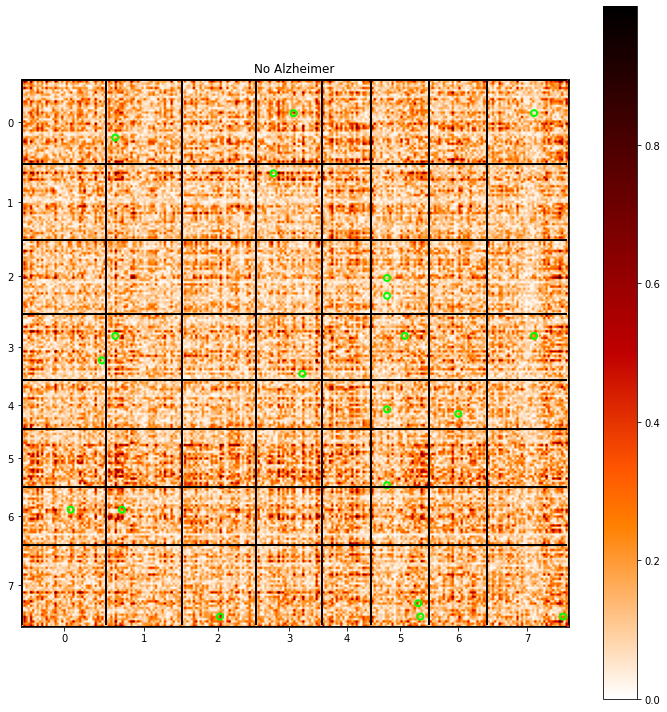

In [178]:
average_maps[0]

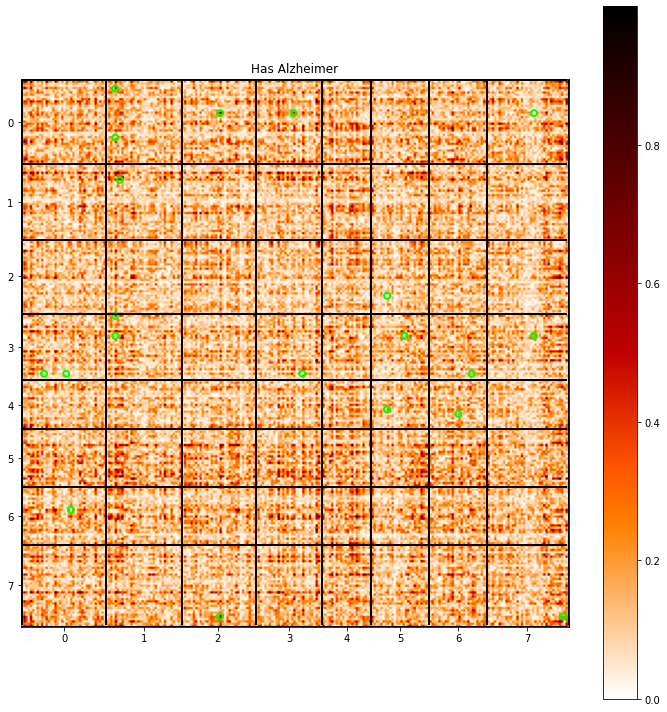

In [177]:
average_maps[1]

In [122]:
a_1d = test.flatten()

# Find the indices in the 1D array
idx_1d = a_1d.argsort()[-20:]

# convert the idx_1d back into indices arrays for each dimension
x_idx, y_idx = np.unravel_index(idx_1d, test.shape)

# Check that we got the largest values.
for x, y, in zip(x_idx, y_idx):
   print(x,y)

44 111
156 9
44 45
44 22
44 135
214 148
10 9
44 39
44 179
44 148
44 122
44 9
44 126
10 132
44 150
44 7
44 235
10 33
44 33
44 132


In [70]:
test = average_maps[3] - average_maps[1]

In [71]:
test.shape

(246, 246)

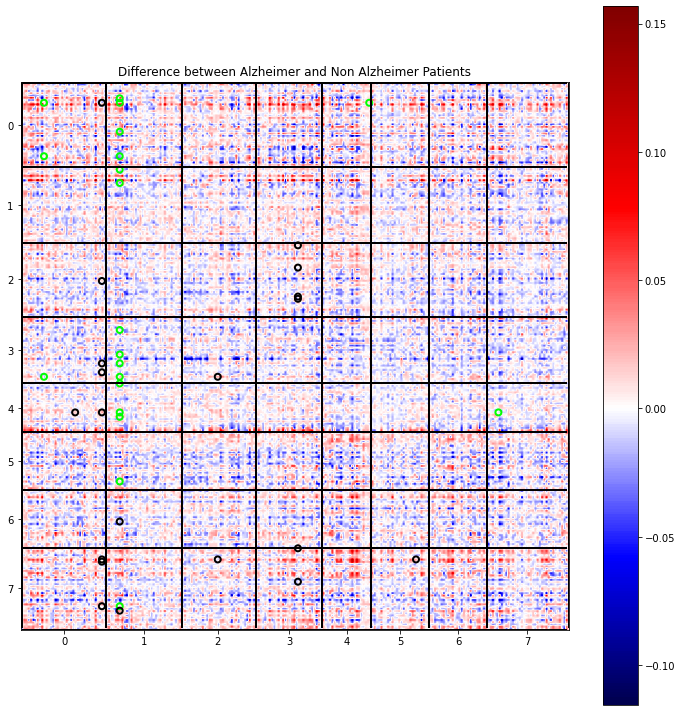

In [119]:
plot_feature_map(test, "Difference between Alzheimer and Non Alzheimer Patients")

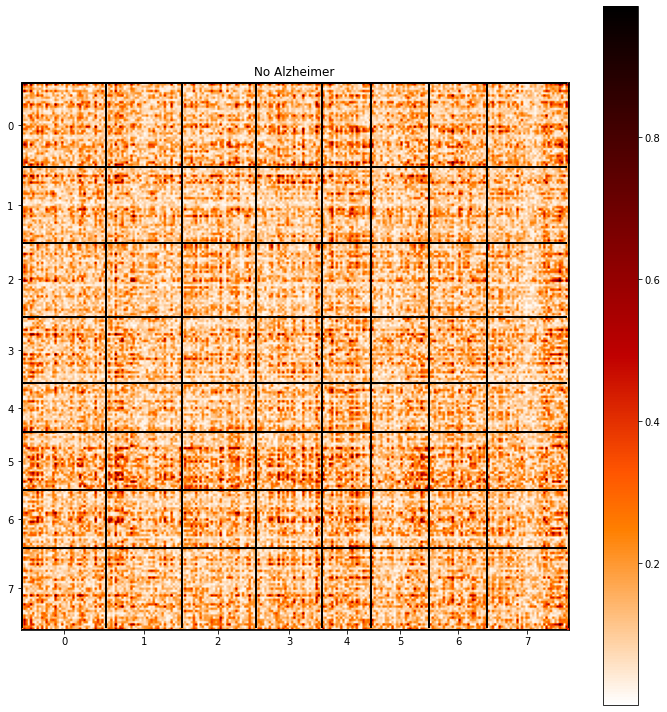

In [74]:
average_maps[0]

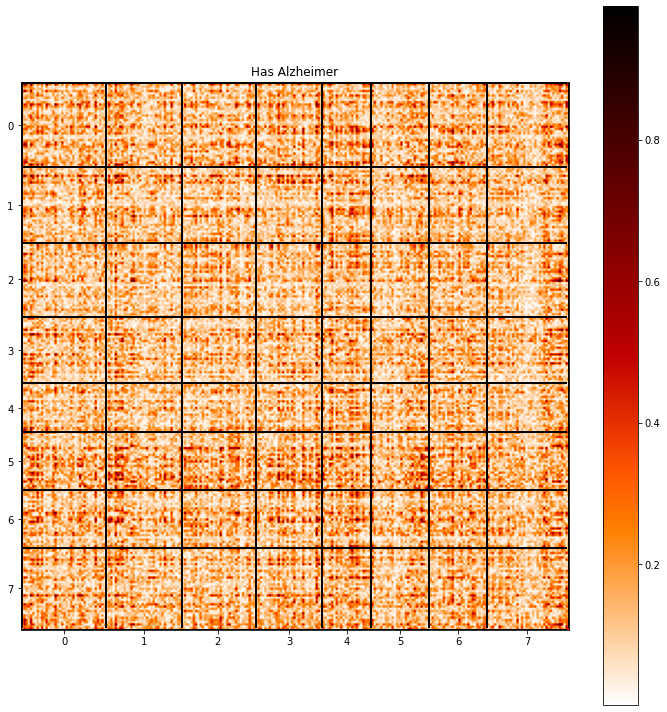

In [62]:

average_maps[2]

In [ ]:
cam = Saliency(brainnetcnn,
                model_modifier=replace2linear,
                clone=True)

feature_map = cam(score_function,
                  [tf.cast(X_test, dtype=tf.float32), tf.cast(X_test_struc, dtype=tf.float32)])


In [ ]:
feature_map

In [ ]:
average_maps[0]

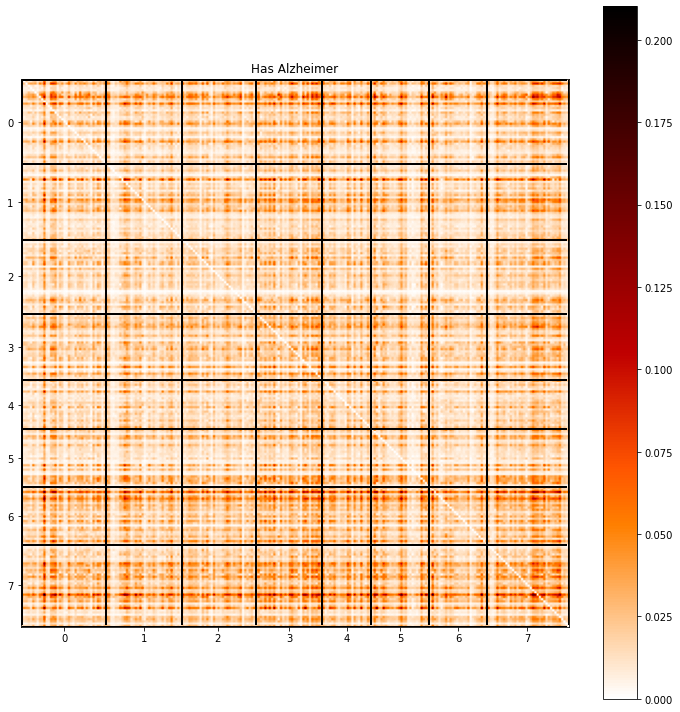

In [ ]:
average_maps[1]

In [ ]:
average_maps[0].savefig('No_Alzheimer_average_Brainnet_cnn.png', dpi=average_maps[0].dpi)
average_maps[1].savefig('Has_Alzheimer_average_Brainnet_cnn.png', dpi=average_maps[1].dpi)

5

In [185]:
average_maps[4].savefig('Final_Alzheimer_plot_Brainnet_cnn_4.png', dpi=average_maps[4].dpi)

### Visualizations helpers

In [ ]:
replace2linear = ReplaceToLinear()

In [ ]:
ordered_roi, ordered_region = ordered_regions()

In [ ]:
ordered_region = list(map(int, ordered_region))

In [ ]:
hlines = []
for i in range(len(ordered_region)-1):
    if ordered_region[i] < ordered_region[i+1]:
      hlines.append(i)

In [ ]:
temp = hlines
temp.append(246)
temp.insert(0,0)
ticks = []
for i in range(len(temp)-1):
    ticks.append(np.round(np.mean([temp[i], temp[i+1]])))

In [ ]:
ticklabel = ["0","1","2","3","4","5","6","7"]

### Saliency Map

In [ ]:
from tf_keras_vis.saliency import Saliency
saliency = Saliency(model_viz,
                    model_modifier=ReplaceToLinear(),
                    clone=True)

In [ ]:
X_train[0:3].shape

(3, 8, 8, 1)

In [ ]:
# Generate saliency map
saliency_map = saliency(score_function, [tf.cast(X_test[0], dtype=tf.float32), tf.cast(X_test_struc[0], dtype=tf.float32)])

In [ ]:
saliency_map[0]

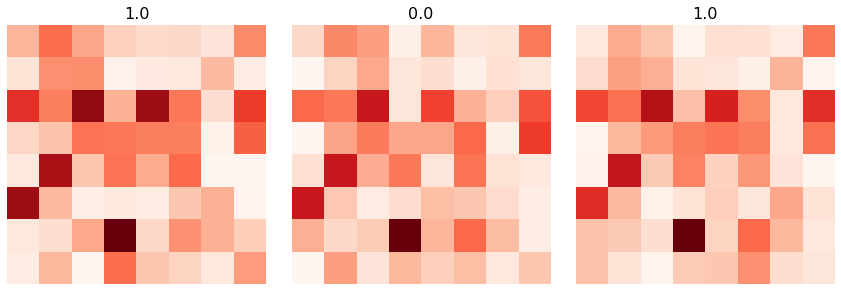

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(y_test[0:3]):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[0][i], cmap='Reds')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

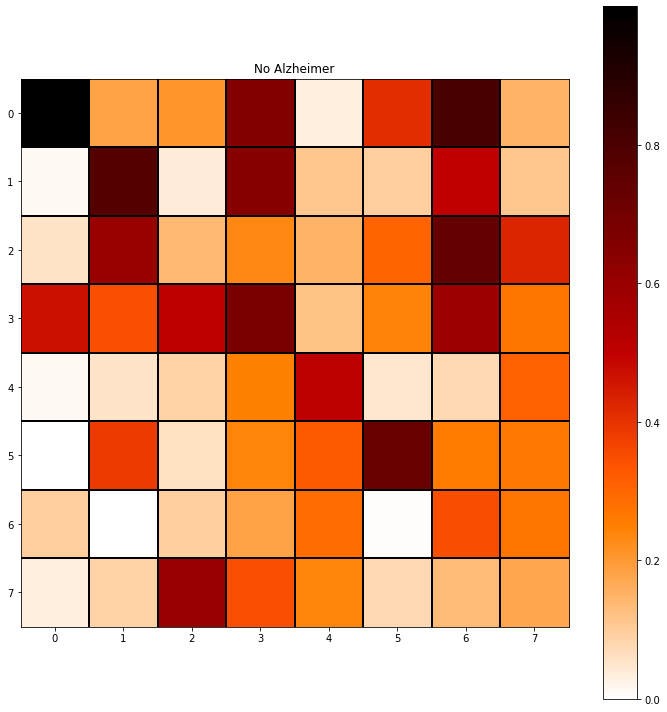

In [ ]:
i = 252
X = X_train[i]
y = y_train[i]

if y ==1:
    title = "Has Alzheimer"
else:
    title = "No Alzheimer"
saliency_map = saliency(score_function, X)

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(saliency_map[0], cmap='gist_heat_r')
plt.colorbar()
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_yticks([0,1,2,3,4,5,6,7])
ax.set_xticklabels(ticklabel)
ax.set_yticklabels(ticklabel)

plt.hlines([0.5,1.5,2.5,3.5,4.5,5.5,6.5],-0.5,7.5,linewidth = 2)
plt.vlines([0.5,1.5,2.5,3.5,4.5,5.5,6.5],-0.5,7.5,linewidth = 2)
plt.title(title)
plt.tight_layout()

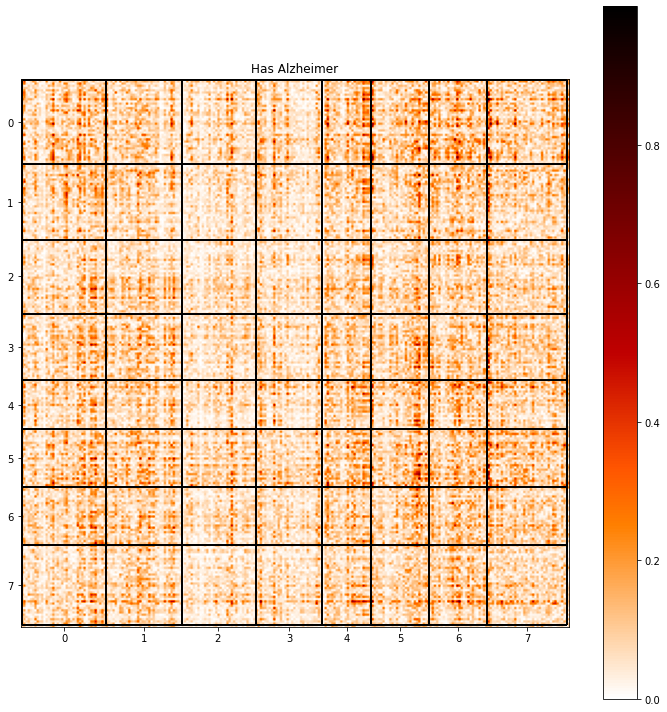

In [ ]:
i = 252
X = X_train[i]
y = y_train[i]

if y ==1:
    title = "Has Alzheimer"
else:
    title = "No Alzheimer"
saliency_map = saliency(score_function, X)

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(saliency_map[0], cmap='gist_heat_r')
plt.colorbar()
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticklabel)
ax.set_yticklabels(ticklabel)

plt.hlines(hlines,0,245,linewidth = 2)
plt.vlines(hlines,0,245,linewidth = 2)
plt.title(title)
plt.tight_layout()

In [ ]:
if y ==1:
    fig.savefig('Alzheimer_' + str(i) + '.png', dpi=fig.dpi)
else:
    fig.savefig('No_Alzheimer_' + str(i) + '.png', dpi=fig.dpi)

### Grad Cam

In [ ]:
# Create Gradcam object
gradcam = Gradcam(model_viz,
                  model_modifier=replace2linear,
                  clone=True)


In [ ]:
model.inputs

[<KerasTensor: shape=(None, 8, 8, 1) dtype=float32 (created by layer 'input_img')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'input_struc')>]

In [ ]:
X_test[0:3].shape

(3, 246, 246, 1)

In [ ]:
# Generate heatmap with GradCAM
cam = gradcam(score_function,
              [tf.cast(X_test[0:1], dtype=tf.float32), tf.cast(X_test_struc[0:1], dtype=tf.float32)],
              expand_cam = True,
              normalize_cam = False)

RuntimeError: ignored

In [ ]:
cam

<tf.Tensor: shape=(1, 1, 1), dtype=float32, numpy=array([[[0.]]], dtype=float32)>

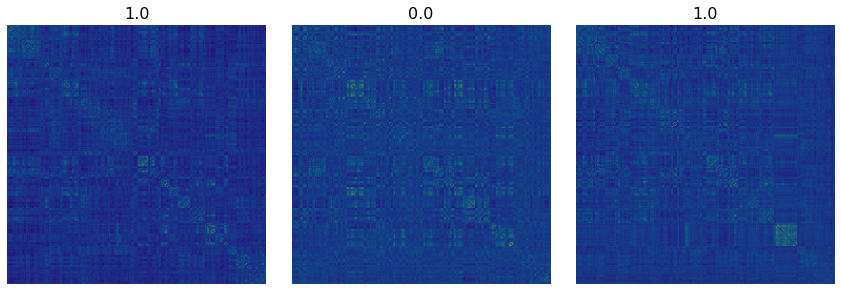

In [ ]:
# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(y_train[0:3]):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(X[i].reshape((246,246)))
    ax[i].imshow(cam[i], cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

(246, 246)

### Grad Cam ++

In [ ]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)

In [ ]:
# Generate heatmap with GradCAM++
cam = gradcam(score_function,
              X,
              penultimate_layer=-1)


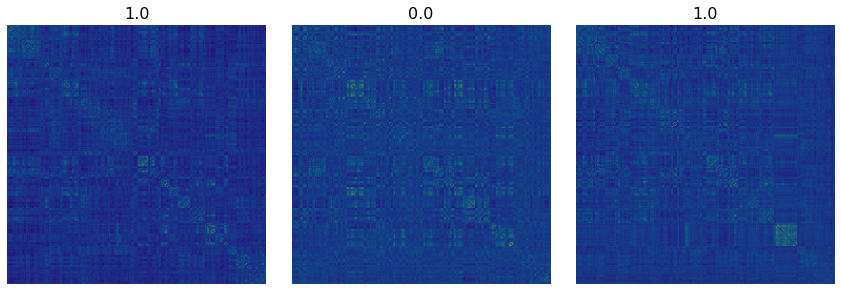

In [ ]:
# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(y_train[0:3]):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(X[i].reshape((246,246)))
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()